In [1]:

#pip install nltk

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
nltk.download ('wordnet')
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

import re


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erice\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erice\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
df = pd.read_csv(r'C:\Users\erice\projects\ChatGPT-Text-Analysis\data\chatgpt-reddit-comments.csv')
df.shape
df.head()

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT


<AxesSubplot:>

Text(0.5, 0, 'SubReddit')

Text(0, 0.5, 'Number of Comments')

Text(0.5, 1.0, 'Data Frequency for SubReddit')

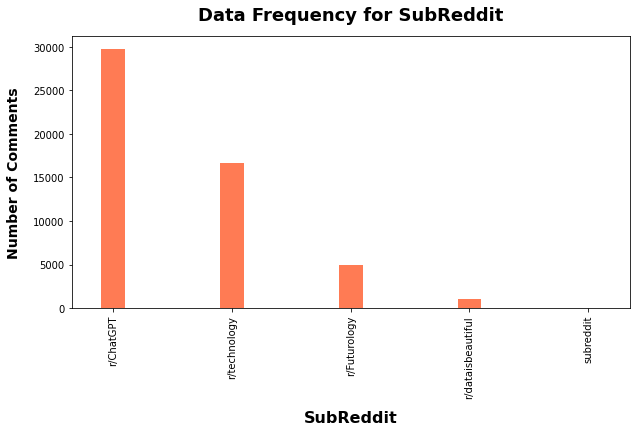

In [4]:
df['subreddit'].value_counts().sort_values(ascending = False).plot(kind='bar', figsize=(10,5), width=0.2, color="#FF7B54")

plt.xlabel("SubReddit", fontsize=16, fontweight="semibold", labelpad=12)
plt.ylabel("Number of Comments", fontsize=14, fontweight="semibold", labelpad=12)
plt.title("Data Frequency for SubReddit", fontsize=18,pad=16, fontweight="bold")

plt.show()

In [5]:
#Check for/Remove NULL values
df.dropna(inplace=True)
df.isnull().value_counts()
df.head()

Unnamed: 0  comment_id  comment_parent_id  comment_body  subreddit
False       False       False              False         False        52412
dtype: int64

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
0,0,iztdxuh,t3_zj2aeu,"I've been shocked for days now, I don't need c...",r/ChatGPT
1,1,iztn0q0,t3_zj2aeu,\n\nI am so angry right now. I just wasted my...,r/ChatGPT
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring is here folks! just when...,r/ChatGPT
3,3,iztfhtb,t3_zj2aeu,"Worked on me, ngl.",r/ChatGPT
4,4,izu2as9,t3_zj2aeu,"Certified 10/10, must-see moment. It really di...",r/ChatGPT


In [16]:
stop_words = set(stopwords.words('english'))
#stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
def clean_comments(comment):
    #Normalize text
    comment = comment.lower()

    #Remove special characters/URLS and '@' tags and non numbers/letters
    comment = re.sub(r"(@\[A-Za-z0-9]+)|([^A-Za-z])|(\w+:\/\/\S+)|^rt|http.+?", " ", comment)

    #Remove linebreaks
    comment = re.sub(r"\n", " ",comment)
    
    #Remove non-words/single characters
    comment = re.sub(r"(^| ).(( ).)*( |$)", " ", comment)

    #Remove stopwords and lemmatize
    word_tokens = word_tokenize(comment)
    clean_token_list = []
    for word_token in word_tokens:
        if word_token not in stop_words:
            clean_token_list.append(lemmatizer.lemmatize(word_token))
    
    clean_comment = " ".join(clean_token_list)
    
    return clean_comment


In [17]:

clean_comments(df.comment_body[52414])

'know referring tos section seem noteworthy'

In [13]:
df.comment_body[52414]

"Don't know what they're referring to in the TOS but these sections seem noteworthy?\n\n* 2(c)\n* 3(c)(d)\n* 5(a)(c)\n* 6(a)\n* 8\n* 9(i)(k)"

In [23]:
cleaned_df = df.copy()
cleaned_df['comment_body'] = df.comment_body.apply(lambda x: clean_comments(x))

In [24]:
# Generating TF-IDF Vector for KMeans from the comment_body
vectorizer = TfidfVectorizer(
                                lowercase=True,
                                ngram_range = (1,3),
                                stop_words = "english"                                
                            )

tf_idf = vectorizer.fit_transform(cleaned_df.comment_body)

In [31]:
from IPython.display import display
cleaned_df

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
0,0,iztdxuh,t3_zj2aeu,shocked day need clickbait,r/ChatGPT
1,1,iztn0q0,t3_zj2aeu,angry right wasted time reading post sub click...,r/ChatGPT
2,2,izudrph,t3_zj2aeu,chatgpt karma whoring folk think stream though...,r/ChatGPT
3,3,iztfhtb,t3_zj2aeu,worked ngl,r/ChatGPT
4,4,izu2as9,t3_zj2aeu,certified must see moment really shock core,r/ChatGPT
...,...,...,...,...,...
52410,16667,j4lbiix,t1_j4kgcac,scary thing future text trustworthy either cas...,r/technology
52411,16668,j5m0v6m,t3_10jmvpj,read thank later,r/technology
52412,16669,j5m6aj0,t1_j5m0v6m,missing,r/technology
52413,16670,j5nylax,t1_j5m0v6m,chatgtp think tos,r/technology
